In [4]:
# import libs
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
tickers = ['PTTEP.BK', 'LANNA.BK', 'TIPH.BK', 'GC=F']

In [6]:
thai_rate = 'THB=X'

In [7]:
interval = '1d'
start = '2008-8-1'
end = '2024-8-1'

thai_currency_rate = yf.Ticker(thai_rate)
thb_df = thai_currency_rate.history(interval='1d',start=start,end=end)
thb_df.index = pd.to_datetime(thb_df.index.strftime('%Y-%m-%d'))
DF = dict()

for tk in tickers:
    stock = yf.Ticker(tk)
    stock_df = stock.history(interval='1d',start=start,end=end)
    stock_df.index = pd.to_datetime(stock_df.index.strftime('%Y-%m-%d'))
    if tk == 'GC=F':
        stock_df['Close'] = stock_df['Close'] * thb_df['Close']
    stock_df.dropna(inplace=True)
    stock_df['rets'] = stock_df['Close'].pct_change()
    DF[tk] = stock_df

In [8]:
set = pd.read_csv('./gmean-set.csv')
set['Month-Year'] = pd.to_datetime(set['Month-Year'])
set.set_index('Month-Year', inplace=True)
set = set[set.index.year >= 2008]
last_quarter = set.iloc[-1, -1]

In [6]:
m = 500000 # number of paths
d = 120

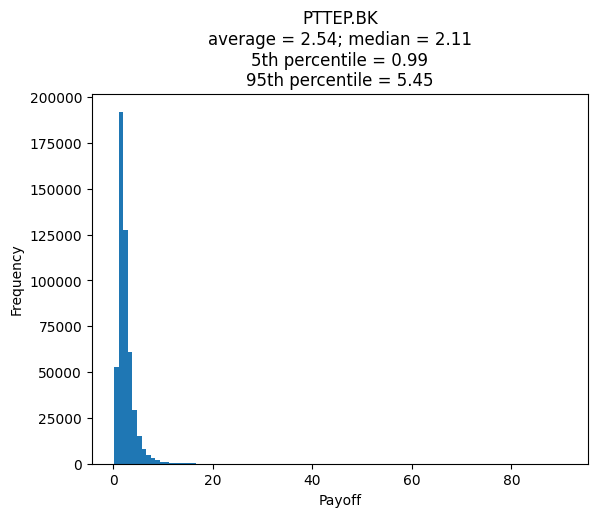

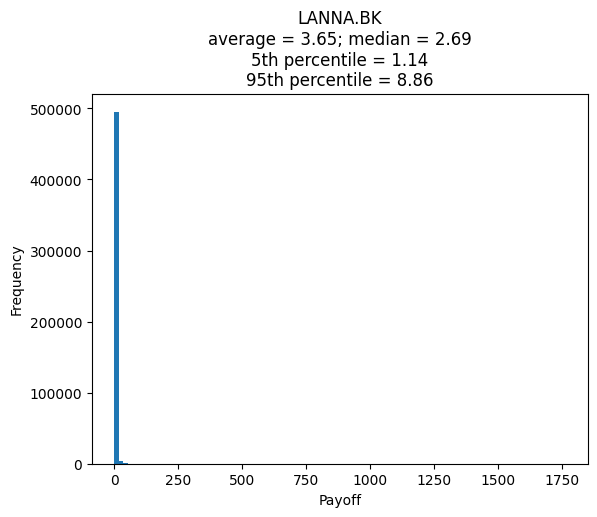

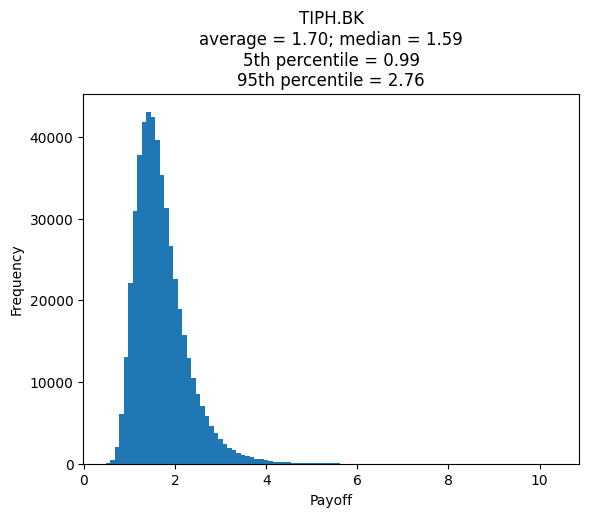

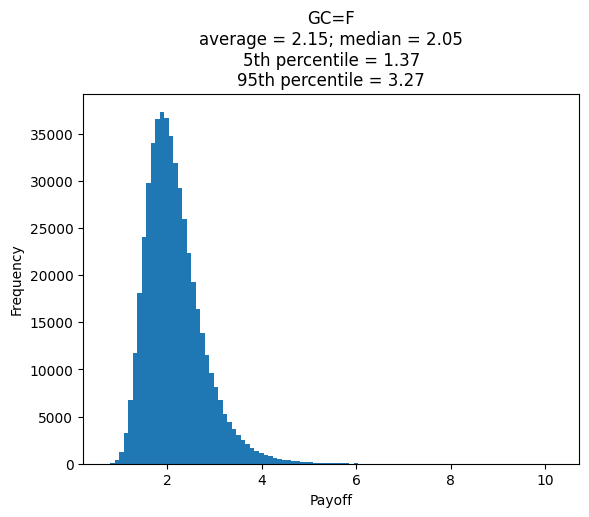

In [8]:
expect_returns = dict() 

for tk in tickers:
    stock_df = DF[tk]
    
    a = np.array([False]*stock_df.shape[0])
    for x in set[set['quarter'] == last_quarter].index:
        a |= (stock_df.index.year == x.year) & (stock_df.index.month == x.month)

    all_returns = []
    for date in stock_df[a].index:
        ret = stock_df.loc[date: date + pd.Timedelta(weeks=16)]['rets'].tolist()
        all_returns.extend(ret)

    rearrange_return = np.random.choice(all_returns, size= (m, d), replace=True)
    portfolios = np.exp(np.cumprod(rearrange_return + 1, axis=1))

    final_portfolios = portfolios[:, -1] - 1
    expect_returns[tk] = final_portfolios
    
    med = np.median(final_portfolios)
    avg = np.average(final_portfolios)
    per_5 = np.percentile(np.sort(final_portfolios), 5)
    per_95 = np.percentile(np.sort(final_portfolios), 95)
    plt.title(f'{tk}\naverage = {avg:.2f}; median = {med:.2f}\n5th percentile = {per_5:.2f}\n95th percentile = {per_95:.2f}')
    plt.xlabel('Payoff')
    plt.ylabel('Frequency')
    plt.hist(final_portfolios, 100)
    plt.show();

In [9]:
from itertools import combinations
from tqdm import tqdm

In [10]:
def proportion_for_optimal_median(asset1, asset2):
    max_med = 0
    max_proportion = 0
    for stock_proportion in tqdm(np.linspace(0.0, 1.0, 101)):
        strategy_simulated_ret = stock_proportion * asset1 + (1 - stock_proportion) * asset2
        med = np.median(strategy_simulated_ret)

        if med > max_med:
            max_med = med
            max_proportion = stock_proportion
            
    return {'prop1': max_proportion, 'prop2': 1 - max_proportion}

In [11]:
comb = list(combinations(tickers, 2))

In [12]:
proportion_asset1 = []
proportion_asset2 = []
avgs_asset1 = []
avgs_asset2 = []
meds_asset1 = []
meds_asset2 = []

ticks = []

avgs_st = []
meds_st = []
per_95_asset_st_list = []
per_5_asset_st_list = []

for ast1, ast2 in comb:
    ticks.append(f'{ast1}-{ast2}')
    
    rest = proportion_for_optimal_median(expect_returns[ast1], expect_returns[ast2])

    avgs_asset1.append(np.mean(expect_returns[ast1]))
    avgs_asset2.append(np.mean(expect_returns[ast2]))
    meds_asset1.append(np.median(expect_returns[ast1]))
    meds_asset2.append(np.median(expect_returns[ast2]))
    
    proportion_asset1.append(rest['prop1'])
    proportion_asset2.append(rest['prop2'])
    
    mixed_rets = expect_returns[ast1] * rest['prop1'] + expect_returns[ast2] * rest['prop2']

    avgs_st.append(np.mean(mixed_rets))
    meds_st.append(np.median(mixed_rets))
    per_95_asset_st_list.append(np.quantile(mixed_rets, 0.95))
    per_5_asset_st_list.append(np.quantile(mixed_rets, 0.05))

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:01<00:00, 94.20it/s]


In [13]:
data = {
    'tickers': ticks,
    
    'median-asset1': meds_asset1,
    'average-asset1': avgs_asset1,
    
    'median-asset2': meds_asset2,
    'average-asset2': avgs_asset2,
    
    '5-percentil-st': per_5_asset_st_list,
    '95-percentil-st': per_95_asset_st_list,
    'median-st': meds_st,
    'average-st': avgs_st,
    
    'proportion-asset1': proportion_asset1,
    'proportion-asset2': proportion_asset2
}

In [14]:
res_df = pd.DataFrame(data)

In [15]:
res_df

,tickers,median-asset1,average-asset1,median-asset2,average-asset2,5-percentil-st,95-percentil-st,median-st,average-st,proportion-asset1,proportion-asset2
0,PTTEP.BK-LANNA.BK,2.109378,2.544507,2.689002,3.654746,1.136097,8.857620,2.689002,3.654746,0.00,1.00
1,PTTEP.BK-TIPH.BK,2.109378,2.544507,1.590625,1.697193,0.989894,5.454509,2.109378,2.544507,1.00,0.00
2,PTTEP.BK-GC=F,2.109378,2.544507,2.054625,2.153449,1.440285,3.680331,2.158333,2.317693,0.42,0.58
3,LANNA.BK-TIPH.BK,2.689002,3.654746,1.590625,1.697193,1.136097,8.857620,2.689002,3.654746,1.00,0.00
4,LANNA.BK-GC=F,2.689002,3.654746,2.054625,2.153449,1.136097,8.857620,2.689002,3.654746,1.00,0.00
5,TIPH.BK-GC=F,1.590625,1.697193,2.054625,2.153449,1.369454,3.270745,2.054625,2.153449,0.00,1.00


In [16]:
cost_list = []
benefit_list = []
for i, (p1, p2) in res_df[['proportion-asset1', 'proportion-asset2']].iterrows():
    if p1 >= p2:
        cost = res_df.loc[i, 'average-st'] - res_df.loc[i, 'average-asset1']
        benefit = res_df.loc[i, 'median-st'] - res_df.loc[i, 'median-asset1']
    else:
        cost = res_df.loc[i, 'average-st'] - res_df.loc[i, 'average-asset2']
        benefit = res_df.loc[i, 'median-st'] - res_df.loc[i, 'median-asset2']
    
    cost_list.append(cost)
    benefit_list.append(benefit)

In [17]:
res_df['cost'] = cost_list
res_df['benefit'] = benefit_list
res_df['net'] = res_df['benefit'] + res_df['cost']

In [18]:
res_df

,tickers,median-asset1,average-asset1,median-asset2,average-asset2,5-percentil-st,95-percentil-st,median-st,average-st,proportion-asset1,proportion-asset2,cost,benefit,net
0,PTTEP.BK-LANNA.BK,2.109378,2.544507,2.689002,3.654746,1.136097,8.857620,2.689002,3.654746,0.00,1.00,0.000000,0.000000,0.000000
1,PTTEP.BK-TIPH.BK,2.109378,2.544507,1.590625,1.697193,0.989894,5.454509,2.109378,2.544507,1.00,0.00,0.000000,0.000000,0.000000
2,PTTEP.BK-GC=F,2.109378,2.544507,2.054625,2.153449,1.440285,3.680331,2.158333,2.317693,0.42,0.58,0.164244,0.103708,0.267952
3,LANNA.BK-TIPH.BK,2.689002,3.654746,1.590625,1.697193,1.136097,8.857620,2.689002,3.654746,1.00,0.00,0.000000,0.000000,0.000000
4,LANNA.BK-GC=F,2.689002,3.654746,2.054625,2.153449,1.136097,8.857620,2.689002,3.654746,1.00,0.00,0.000000,0.000000,0.000000
5,TIPH.BK-GC=F,1.590625,1.697193,2.054625,2.153449,1.369454,3.270745,2.054625,2.153449,0.00,1.00,0.000000,0.000000,0.000000


In [21]:
a = expect_returns['PTTEP.BK'] * 0.42 + expect_returns['GC=F'] * 0.58
b = expect_returns['LANNA.BK']

In [22]:
proportion_for_optimal_median(a, b)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 111.11it/s]


{'prop1': 0.0, 'prop2': 1.0}